# Extra implementation for Bonus points
    
- An extra question that could have been asked 
 
- I update the weights with momemtum optimizer for m% of epochs and mini-batch gradient descent optimizer for g% epochs, and see how much loss reduction is achieved in same number of iterations. Then, tune x and y to get best accuracy on validation set. If the accuracy doesnt change much, I am going to optimize for best time taken because momentum optimizer is supposed to converge faster.


## Part 1

#### An extra question that could have been asked

What happens when we initialze weight matrix with 0 and not random numbers ?? Does it take more time for weights to converge or more ?


## Part 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FOLDERNAME = '682/assignment1'

import sys
# sys.path.append('content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.insert(0,'/content/drive/My Drive/{}'.format(FOLDERNAME))

#Get Dataset
# %cd drive/MyDrive/682/assignment1/cs682/datasets/
# !bash get_datasets.sh

In [ ]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
%cd drive/MyDrive/682/assignment1/

/content/drive/MyDrive/682/assignment1


## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)

In [ ]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [ ]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


### Analysis 1:
Training with both mini-batch gradient descent and momentum optimizer for few epochs each and tuning the number of epochs for which to run momentum to achieve best accuracy.

Gradient descent: 
w_new = w_old - learning_rate * gradient

Momentum:
w_new = w_old - V(t) \
where V(t) = momentum_term * V(t-1) + learning_rate * gradient

In [ ]:
# Optimizer Class

from cs682.classifiers.linear_svm import svm_loss_vectorized

class WeirdClassifier(object):
  
  def __init__(self):
    self.W = None

  # m is the % of iterations to run for momentum optimizer
  def train(self, X, y, learning_rate=1e-3, reg=1e-5, momentum_term=0.9, num_iters=100, m=.75,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using mini-batch gradient descent and momentum optimizer

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)
    
    # velocity matrix for momentum
    v = np.zeros_like(self.W)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    epochs_for_momentum = int(m * num_iters)
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      random_idxs = np.random.choice(num_train, batch_size, replace = True)

      X_batch = X[random_idxs, :]
      y_batch = y[random_idxs]

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      if (it < epochs_for_momentum):
        # momentum code
        v = momentum_term*v + learning_rate * grad
        self.W -= v
      else:
        # gradient descent
        self.W -= learning_rate * grad
      
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)
  
  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    scores = X.dot(self.W)
    y_pred = np.argmax(scores, axis=1)
    return y_pred



That took 9.054733s


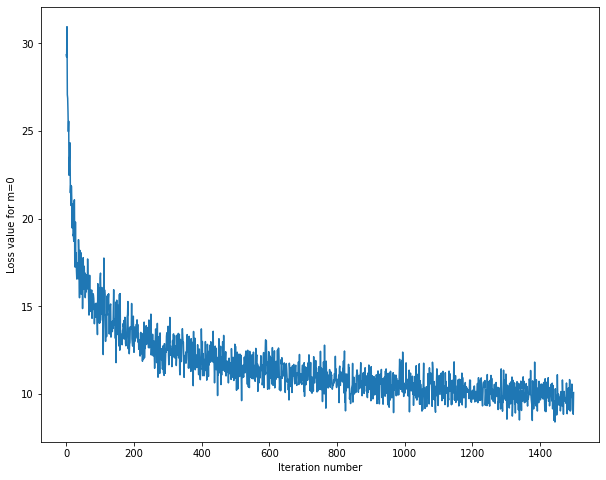

That took 9.801645s


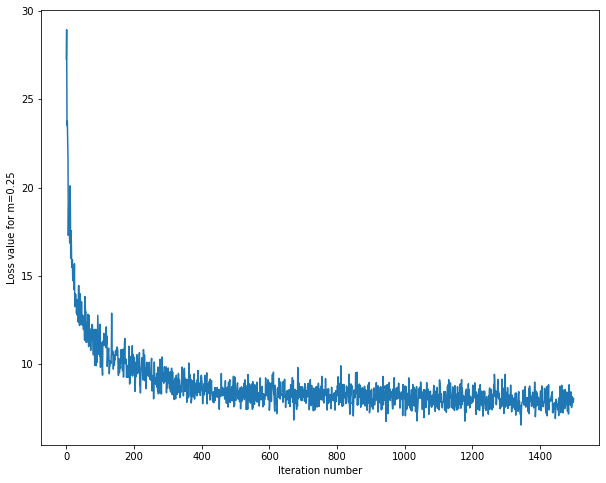

That took 9.722397s


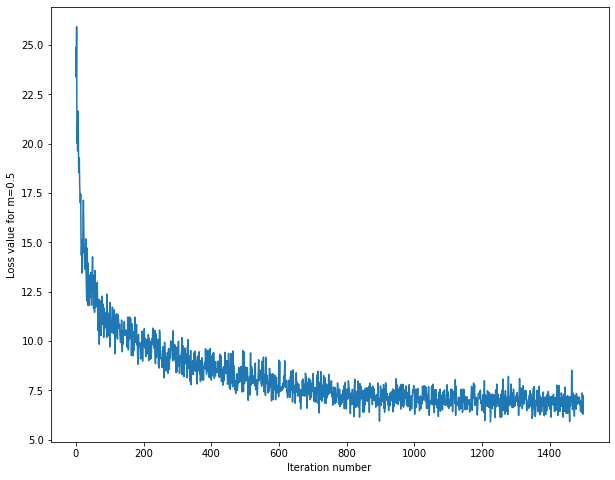

That took 9.750032s


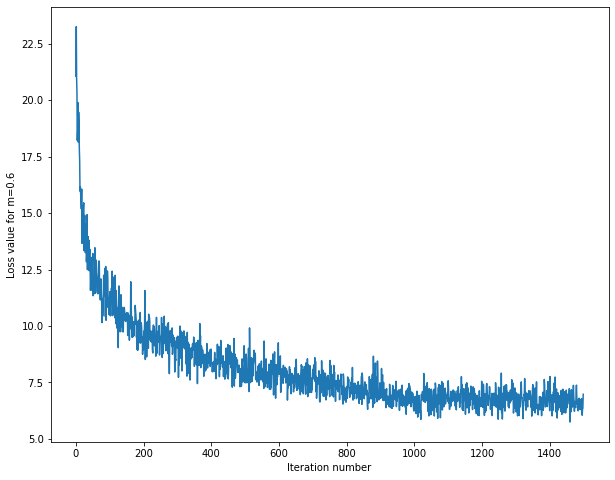

That took 10.006056s


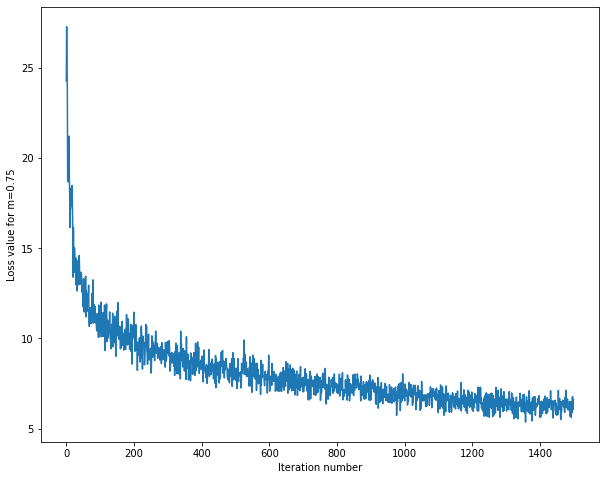

That took 9.485950s


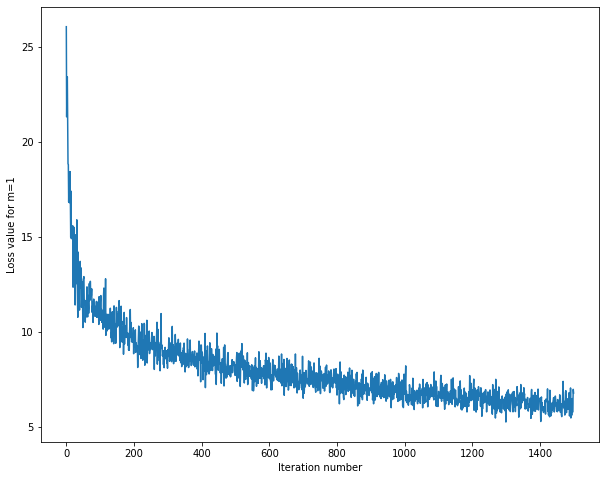

In [ ]:
import time

ms=[0, 0.25, 0.50, 0.60, 0.75, 1]
loss_reduction = []
for m in ms:
  svm = WeirdClassifier()
  tic = time.time()
  loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, momentum_term=0.9, 
                        num_iters=1500, m=m, verbose=False)
  toc = time.time()
  loss_reduction.append(loss_hist[-1])
  print('That took %fs' % (toc - tic))
  plt.plot(loss_hist)
  plt.xlabel('Iteration number')
  plt.ylabel(f'Loss value for m={m}')
  plt.show()


Text(0.5, 0, 'm values')

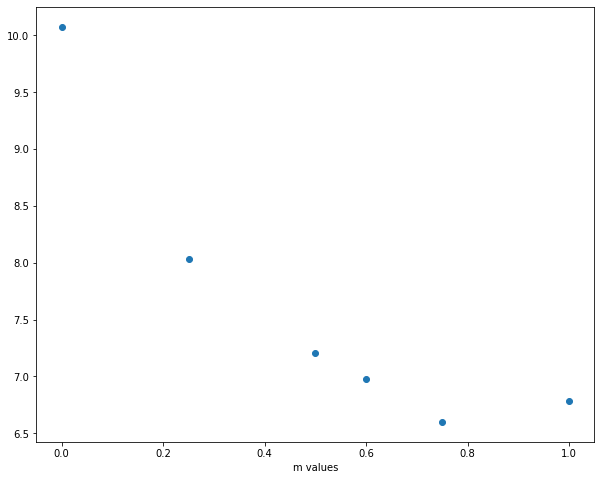

In [ ]:
# as m increases we arrive at a smaller loss after 1500 iterations
plt.scatter([0, 0.25, 0.5, 0.6, 0.75, 1], loss_reduction)
plt.xlabel('m values')

In [ ]:
# Normal accuracy without my change is ~30% (checks everything with m=0)

m_array = [0, 0.25, 0.50, 0.75]
momentum_terms = [0.9]
learning_rates = [1e-7, 3e-6, 5e-6, 7e-7]
regularization_strengths = [2.5e4, 5e4, 7.5e4, 1e5]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates:
  for reg in regularization_strengths:
    for m in m_array:
      for momentum_term in momentum_terms:
        clf = WeirdClassifier()
        clf.train(X_train, y_train, lr, reg, momentum_term,  100, m, 200, False)
        
        y_pred_train = clf.predict(X_train)
        y_pred_val = clf.predict(X_val)
        train_ac = np.mean(y_pred_train == y_train)
        val_ac = np.mean(y_pred_val == y_val)

        results[(lr, reg, m, momentum_term)] = (train_ac, val_ac)

        # saving the classifier if it has better accuracy till now
        if (val_ac > best_val):
          best_val = val_ac
          best_svm = clf
    
# Print out results.
for lr, reg, m, momentum_term in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, m, momentum_term)]
    print('lr %e reg %e m %e momentum_term %e train accuracy: %f val accuracy: %f' % (
                lr, reg, m, momentum_term, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 m 0.000000e+00 momentum_term 9.000000e-01 train accuracy: 0.207184 val accuracy: 0.200000
lr 1.000000e-07 reg 2.500000e+04 m 2.500000e-01 momentum_term 9.000000e-01 train accuracy: 0.249939 val accuracy: 0.256000
lr 1.000000e-07 reg 2.500000e+04 m 5.000000e-01 momentum_term 9.000000e-01 train accuracy: 0.272143 val accuracy: 0.278000
lr 1.000000e-07 reg 2.500000e+04 m 7.500000e-01 momentum_term 9.000000e-01 train accuracy: 0.281082 val accuracy: 0.281000
lr 1.000000e-07 reg 5.000000e+04 m 0.000000e+00 momentum_term 9.000000e-01 train accuracy: 0.212776 val accuracy: 0.232000
lr 1.000000e-07 reg 5.000000e+04 m 2.500000e-01 momentum_term 9.000000e-01 train accuracy: 0.253796 val accuracy: 0.275000
lr 1.000000e-07 reg 5.000000e+04 m 5.000000e-01 momentum_term 9.000000e-01 train accuracy: 0.269776 val accuracy: 0.278000
lr 1.000000e-07 reg 5.000000e+04 m 7.500000e-01 momentum_term 9.000000e-01 train accuracy: 0.276184 val accuracy: 0.274000
lr 1.000000e-07 

Best loss occurs at m=0.5 and other params being:  \
lr 3e-6, reg 2.5e+04, m 0.75, momentum_term 0.9, train accuracy: 0.3533, val accuracy: 0.3650. So now val accuracy ~36%, original we could do ~30% without momentum.


In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.325000
